# Predicting Match Outcomes for the FIFA Women's World Cup 2019
*A case study in Bayesian modeling*

by Derek Miller

## Introduction

One way to predict match outcomes from tournament-style sporting events like the FIFA World Cup is to set up the problem as a matrix completion problem. For this case study, I will be using data I collected during the FIFA Women's World Cup 2019.

This case study presents a Bayesian approach to predicting the outcome of a tournament-style sporting event. In this case, we're going to be looking at the 2019 FIFA Women's World Cup. The tournament structure for a FIFA World Cup lends itself nicely to Bayesian analysis. Here's how the tournament is structured for the 2019 Women's World Cup.

*Group Phase*

The first stage of the tournament is called the group phase. Each of 24 teams are assigned to a group with 3 other teams. Each team will compete in at least 3 matches, one for every other team in their group. The match duration is 90 minutes. The possible outcomes for a team are a win, a loss, or a draw. Points are awarded for each outcome: 3 points for a win, 1 point for a draw, 0 points for a loss. The top 16 teams with the most points after the group stage advance to the knockout phase of the tournament.

*Knockout Phase*

The second stage of the tournament is the knockout phase, where a team must win to advance. No draws are allowed in this stage. When two teams are tied at the end of 90 minutes, the match continues for two additional 15-minute periods. If the teams are still tied at the end of extra time, the match proceeds to penalty kicks to determine the winner.

What follows is a sample of the dataset we will work with. The variables are the number of goals scored, number of attempts to score, how many attempts were on-target, and how many attempts were off-target. From those numbers, I also created two variables for convenience, the rate at which shots were on-target in a match and the rate at which the keeper failed to save a shot that was on-target.

In [24]:
import numpy as np
import utils
import vis
from importlib import reload
reload(vis)

df = utils.get_df()
df.sample(10)

,group,team,game,opponent,attempts,on_target,off_target,goals_for,goals_against,on_target_against,on_target_rate,fail_to_save_rate
93,X,NETHERLANDS,5,ITALY,21,9,8,2,0,2,0.428571,0.000000
74,W,NORWAY,4,AUSTRALIA,27,8,11,1,1,4,0.296296,0.250000
60,D,JAPAN,3,ENGLAND,16,5,10,0,2,6,0.312500,0.333333
21,F,SWEDEN,1,CHILE,25,7,11,2,0,1,0.280000,0.000000
43,E,NEW ZEALAND,2,CANADA,2,0,2,0,2,6,0.000000,0.333333
81,W,USA,4,SPAIN,12,3,8,2,1,1,0.250000,1.000000
44,F,SWEDEN,2,THAILAND,34,15,16,5,1,3,0.441176,0.333333
49,B,SPAIN,3,CHINA,24,9,9,0,0,0,0.375000,NaN
55,A,NORWAY,3,KOREA,8,2,4,2,1,7,0.250000,0.142857
101,Z,SWEDEN,7,ENGLAND,9,8,1,2,1,4,0.888889,0.250000


## Problem Setup

To predict the winner of the tournament, we need to be able to answer the question: what would the outcome have been if Team X had played Team Y? This scenario is called a counterfactual. where each team plays every other team in the tournament. To do this, let's create a list of teams where each team is indexed from 1-24, ordered first by their group (A-F) then by their rank within their group.

In [2]:
for i,team in enumerate(utils.teams):
    print(i+1,'\t',team)

1 	 FRANCE
2 	 NORWAY
3 	 NIGERIA
4 	 KOREA
5 	 GERMANY
6 	 SPAIN
7 	 CHINA
8 	 SOUTH AFRICA
9 	 ITALY
10 	 AUSTRALIA
11 	 BRAZIL
12 	 JAMAICA
13 	 ENGLAND
14 	 JAPAN
15 	 ARGENTINA
16 	 SCOTLAND
17 	 NETHERLANDS
18 	 CANADA
19 	 CAMEROON
20 	 NEW ZEALAND
21 	 USA
22 	 SWEDEN
23 	 CHILE
24 	 THAILAND


Now let's create a 24x24 matrix with entries corresponding to the number of goals team $i$ scored against team $j$ in the group stage. The color corresponds to the numeric value of the goals scored with grey corresponding to empty values in the matrix. The empty values are exactly the values we want to fill. That is, we want to compute $E[g_{i,j}]$ where $g$ is the number of goals scored by team $i$ against team $j$.

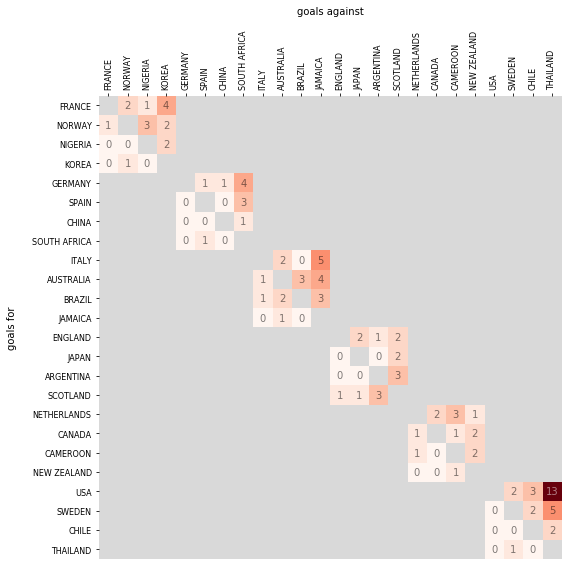

In [25]:
G = utils.get_goal_matrix(m=1,n=3) # the group stage scores
vis.plot_goal_matrix(np.round(G))

## Attempt 1: The MOM Estimator

Arguably, the simplest way to estimate $E[g_{i,j}]$ is to use the Method-of-Moments (MOM) estimator. The way to do this is

$E[g_{i,j}] = E[attempts * on\_target\_rate * fail\_to\_save\_rate]$.

For simplicity, let's assume that $attempts_i$, $on\_target\_rate_i$, and $fail\_to\_save\_rate_j$ are independent. This is a strong assumption but (spoiler alert!) this is not going to be our final model anyway. Assuming independence, we can separate out the expectation operator for each of the variables.

$E[g_{i,j}] = E[attempts_i] * E[on\_target\_rate_i] * E[fail\_to\_save\_rate_j]$.

The MOM tells us we can just substitute each of these expectations with the empirically observed averages from the data. I built a function to do just that called `EG_matrix()`. The matrix is printed below.

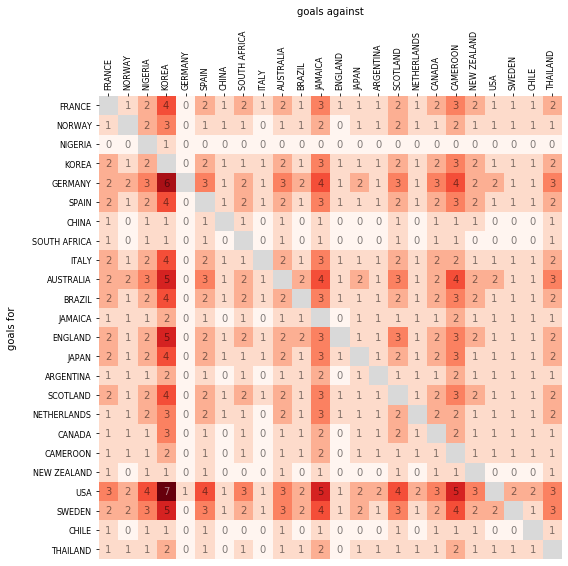

In [26]:
EG_MOM = utils.EG_matrix()
vis.plot_goal_matrix(np.round(EG_MOM))

## Attempt 2: Simple Bayesian Model

The MOM estimator is a simple way to estimate the quality of a team and predict the outcome of a match. With not very much data, we shouldn't place a lot of confidence in the MOM estimator. Scenarios with small amounts of data but some good prior knowledge calls for a more Bayesian approach.

A simple Bayesian model of soccer matches models scored goals as a Poisson distribution, $g_{i,j} \sim Poisson(\theta_{i,j})$. The parameter $\theta_{i,j}$ is a rate parameter which in this example can be interpreted as the average number of goals scored in 90 minutes for team $i$ against team $j$. Note that $\theta_{i,j}$ does not have to be an integer---it can take on any real value greater than zero. We don't really know what $\theta_{i,j}$ is for each team, so maybe we should put a hyperprior on that. How should we choose the hyperparameters? Why not use the MOM estimator for the hyperparameters? What we get is $\theta \sim Normal(\mu, \sigma)$ where $\mu$ is the MOM estimated mean and $\sigma$ is the MOM estimated variance. The full model in Stan is written as follows.

In [5]:
# run the model using only group stage data (matches 1-3)
FIT = utils.run_stan_model('poisson.stan', '2019', m=1, n=3)
print(FIT)

Inference for Stan model: anon_model_aace7765c73ec40c6ee031186a1d1a5d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1,1]     1.91    0.01   0.92   0.29   1.23   1.89   2.53    3.8   4435    1.0
theta[2,1]     1.35  8.5e-3   0.69   0.26   0.84   1.28   1.79   2.84   6518    1.0
theta[3,1]     0.59  6.1e-3   0.48   0.02   0.21   0.48   0.87   1.77   6153    1.0
theta[4,1]     1.13    0.01   0.72   0.07   0.53   1.04   1.58   2.74   4803    1.0
theta[5,1]     2.47    0.01   0.96   0.62    1.8   2.47   3.12   4.39   4613    1.0
theta[6,1]      1.9    0.01   0.91    0.3   1.24   1.86    2.5   3.82   4904    1.0
theta[7,1]     1.08  9.9e-3   0.72   0.05   0.51   0.96   1.54   2.73   5350    1.0
theta[8,1]     1.03  9.5e-3    0.7   0.05   0.47   0.93   1.47   2.62   5367    1.0
theta[9,1]     1.64    0.01   0.88   0.18   0.96    1.6

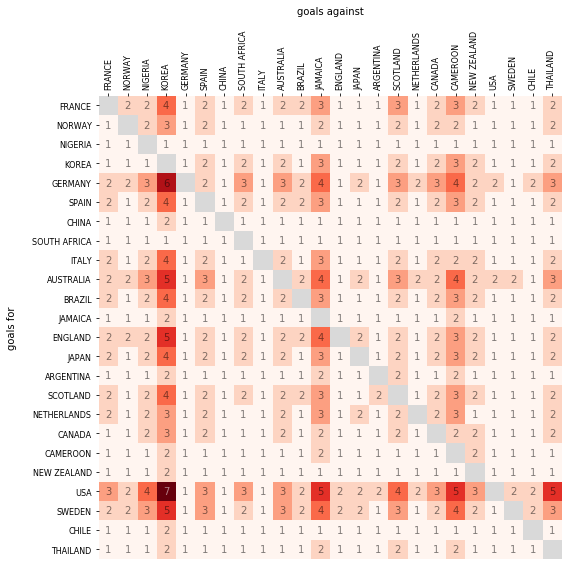

In [27]:
EG_poisson = FIT.extract(pars=['EG'])['EG']
vis.plot_goal_matrix(np.round(EG_poisson.mean(axis=0)))

Convergence and diagnostics indicate that the model seems to have converged. The predictions looks very similar to the MOM estimator matrix. That makes sense because we used the MOM estimator to inform the hyperprior for our Poisson model. Can we do better? (We can.)

## Attempt 3: Structural Poisson Model

One way we can improve this model is by deconstructing the $\theta_{i,j}$ into it's various components. By adding structure to the model, we will improve estimation. Recall how we computed the MOM estimate:

$E[g_{i,j}] = E[attempts_i] * E[on\_target\_rate_i] * E[fail\_to\_save\_rate_j]$.

Let's improve our model by giving each of these independent variables its own hyperprior. For simplicity, we can assign a truncated normal distribution to the number of attempts with the mean and variance computed from the empirical data as before.

To model the on-target and failure-to-save rates, we can use the beta distribution. One way to interpret the two parameters of a beta distribution is as "pseudocounts" for the number of successes and failures respectively of a Bernoulli process.

$rate \sim Beta(\alpha, \beta)$

Thus, we can model the on-target and failure-to-save rates with a beta distribution. Using the on-target rate as an example, the hyperparameter $\alpha$ is chosen to be equal to the number of shots on-target + 1. Likewise, the hyperparameter $\beta$ is chosen to be equal to the number of shots off-target + 1. The addition of the ones has to do with the interpretation of the $Beta(1,1)$ distribution, which is the same as a uniform distribution between 0 and 1. In other words, we know that shots can be on-target and they can be off-target. The failure-to-save rate hyperparameters are chosen similarly with a success being the number of goals scored against the opponent and a failure being the number of shots on-target minus the number of goals scored against the opponent.

Let's see how this model fares.

In [7]:
# use data from group stage only (matches 1-3)
FIT2 = utils.run_stan_model('poisson2.stan', '2019', m=1,n=3, iter=5000)
print(FIT2)

Inference for Stan model: anon_model_5f7680b71b0bbd9eaceb12f7e4e2a56a.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
attempts[1]   17.52    0.04   5.67   8.27  13.35  16.88  20.92  30.36  17166    1.0
attempts[2]   10.32    0.03    3.6   4.39   7.72   9.92  12.53  18.55  16809    1.0
attempts[3]   14.77    0.09  10.17   2.45   7.43  12.33  19.35  40.78  13392    1.0
attempts[4]    5.45    0.03    4.3   0.57   2.45   4.39   7.27  16.89  15252    1.0
attempts[5]   18.43    0.05   6.15   8.51  13.96  17.71  22.17  32.66  14793    1.0
attempts[6]   15.24    0.06   7.56   4.41   9.56  13.97  19.47  33.26  16576    1.0
attempts[7]    12.0    0.11  11.28   1.08   4.69   8.79  15.46  42.33  10546    1.0
attempts[8]    5.71    0.02   2.07   1.86   4.21   5.66    7.1   9.99  13052    1.0
attempts[9]   11.64    0.04   4.49   4.95   8.42  10.9

Convergence and Rhat look great and the model finished much faster which likely indicates that we probably have a better model. Let's look at the predictions.

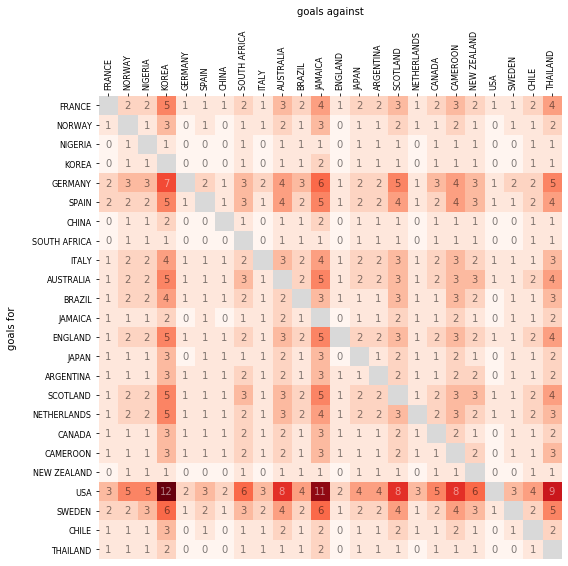

In [28]:
EG_poisson2 = FIT2.extract(pars=['EG'])['EG']
vis.plot_goal_matrix(np.round(EG_poisson2.mean(axis=0)))

Compare to the actual observed goals.

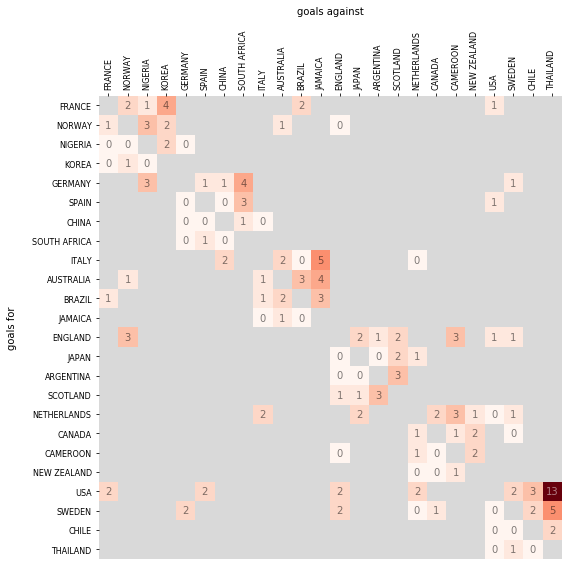

In [29]:
G_all = utils.get_goal_matrix(m=1,n=7)
vis.plot_goal_matrix(G_all)

These predictions are much better than those of the previous two models. By adding structure to the model, we were able to improve the predictions.

## Why Bayes?

There are a few practical reasons why you might want to use Bayesian methods over perfectly valid frequentist methods. Here are a few.

- You don't have a lot of data.
- The data generating process is complex.
- The decision function is complex.
- You want to quantifying uncertainty directly.

In my opinion Bayesian analysis shines best on the last point. Technically speaking, our model didn't compute numbers visualized in the matrix above. The matrix shows the *average* of the results of *10,000 simulations*. In other words, we asked the model to simulate 10,000 matches for each pair of teams using data from the group stage. Accordingly, we can look at the *distribution of outcomes* rather than just one summary statistic. Let's visualize the distribution below.

To start, notice that the actual outcome of USA vs Thailand was 13-0. In 10,000 simulated matches, how many of them ended up with the USA winning by at least 13 points? See the visualizations below.

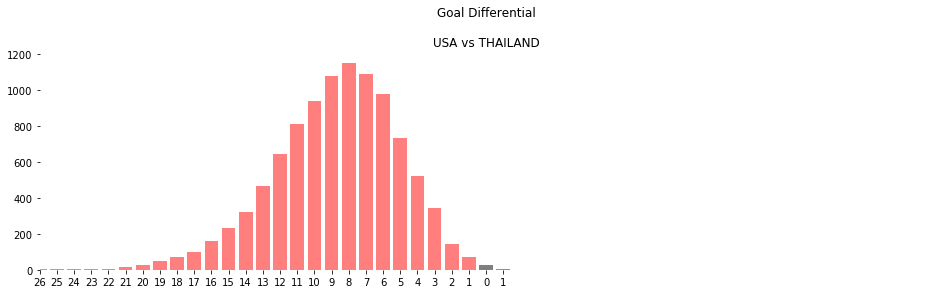

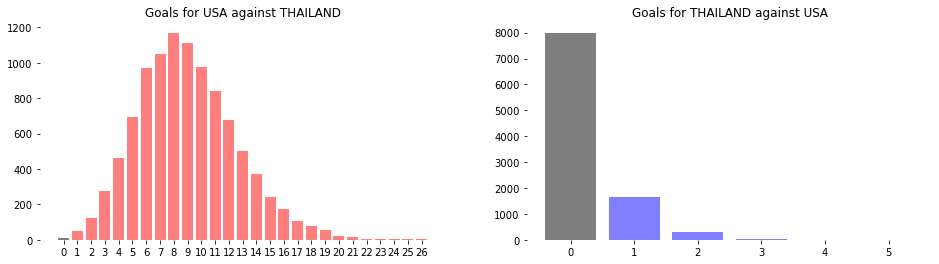

In [30]:
vis.plot_goaldiff("USA", "THAILAND", EG_poisson2)
vis.plot_goals("USA", "THAILAND", EG_poisson2)

Looks like perhaps around 10% of all games ended with the USA winning by at least 13 points. If we were to predict the most likely number of goals team USA would score in a match against Thailand, we would probably say the mode of the bottom distribution, something like 7 or 8. This is the *Maximum a posteriori* or MAP estimate and is typically used for prediction.

Let's take a look at some more competitive games.

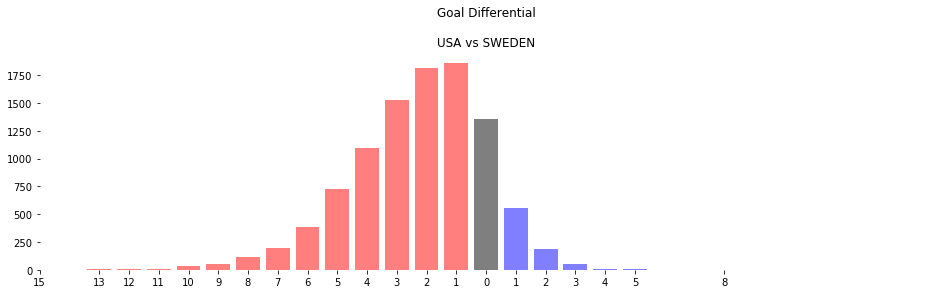

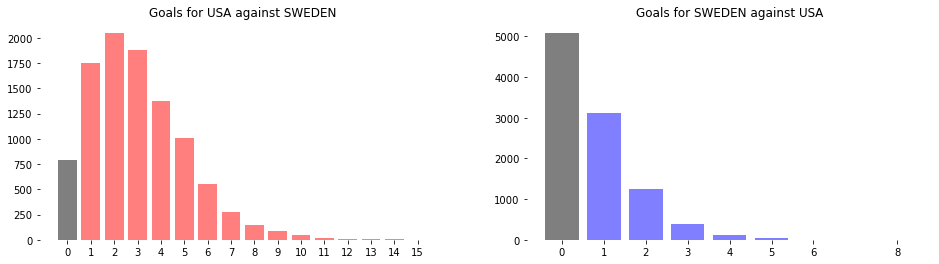

In [31]:
vis.plot_goaldiff("USA", "SWEDEN", EG_poisson2)
vis.plot_goals("USA", "SWEDEN", EG_poisson2)

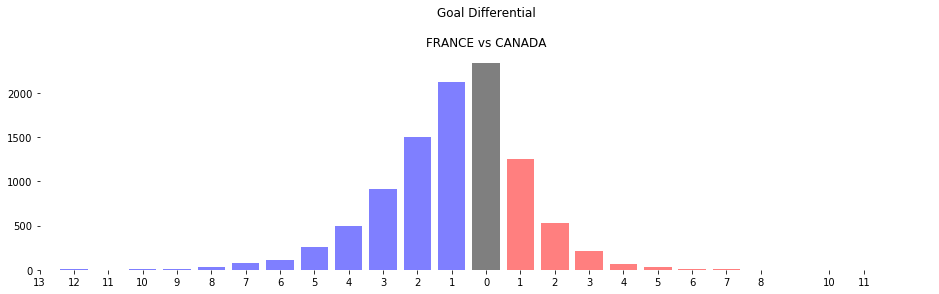

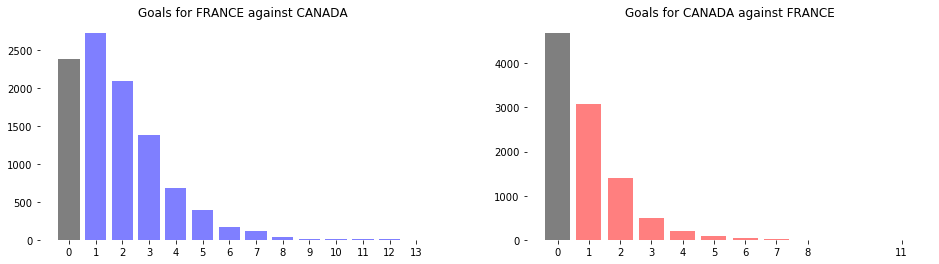

In [32]:
vis.plot_goaldiff("FRANCE", "CANADA", EG_poisson2, color1='blue', color2='red')
vis.plot_goals("FRANCE", "CANADA", EG_poisson2, teamcor=['b','r'])

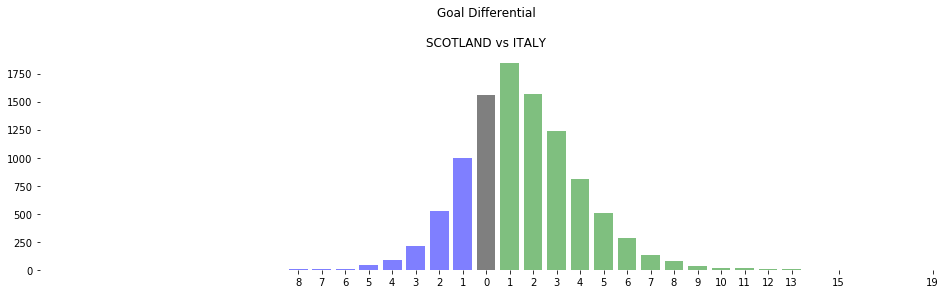

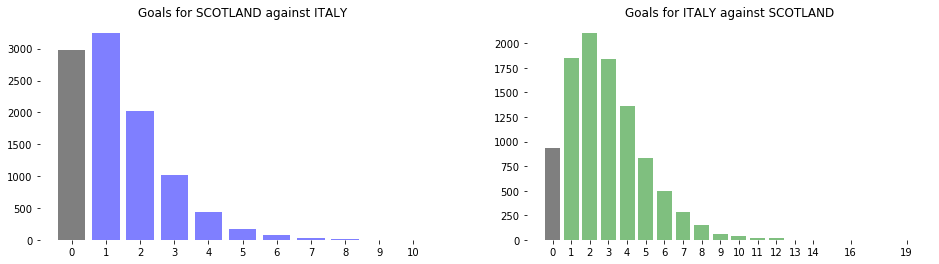

In [33]:
vis.plot_goaldiff("SCOTLAND", "ITALY", EG_poisson2, color1='blue', color2='green')
vis.plot_goals("SCOTLAND", "ITALY", EG_poisson2, teamcor=['blue', 'green'])

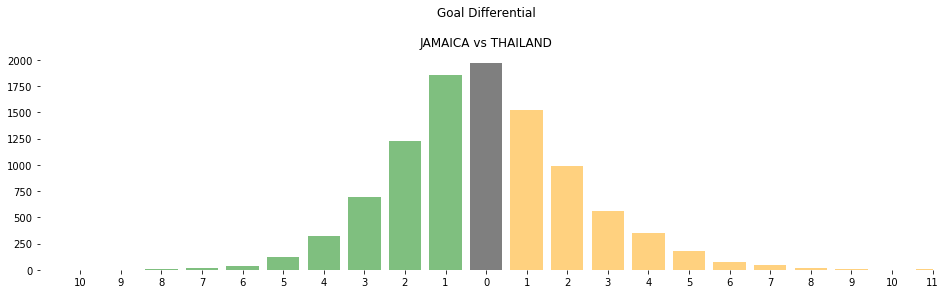

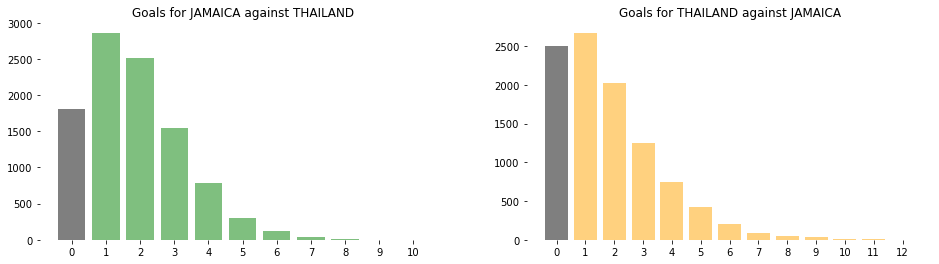

In [34]:
vis.plot_goaldiff("JAMAICA", "THAILAND", EG_poisson2, color1='green', color2='orange')
vis.plot_goals("JAMAICA", "THAILAND", EG_poisson2, teamcor=['green','orange'])

Concluding thought, courtesy of Michael Betancourt (Twitter handle @betanalpha):

*Remember that using Bayes' Theorem doesn't make you a Bayesian. Quantifying uncertainty with probability makes you a Bayesian.*

### Appendix: Even better models

One of the valid critiques of the model above would center around the choice of prior for the number of attempts on goal. The model above chose a half-truncated normal distribution, or a normal distribution where all negative values are mapped to zero. The most natural choice of distribution for attempts would be a poisson. But things are a bit more complicated.

*Aside:  First of all, the poisson distribution for goals scored is mediated by the opponent keeper's ability to save the ball. Similarly, an attempt at goal is a function of the quality of the defense, which is a vague concept that is hard to quantify. In other words, we don't have a variable that clearly tells us the quality of the defense to estimate the poisson distribution of attempts. And even if we did, it turns out that the MCMC routine implemented in this code requires parameters to have a continuous distribution (for reasons I won't go into here). Technically, there is a way that we can use a poisson distribution by actually modeling/fitting the number of attempts to a poisson distribution but that requires specifying another generative parameter which requires us to think about variables that affect a team's ability to get an attempt. This might include things like how good is the home team's offense versus the away team's defense and vice versa. Maybe also ball possession. Maybe also which players are involved. But my goal is just to get a decent prediction for the outcome of a game rather than try to understand and model all the dynamics of a game. So I'm willing to take some shortcuts and this is one of them. Don't @ me.* 

What to do? Well for large values (>100) of `lambda` (the parameter of the poisson distribution interpreted as a rate over a time period) a normal distribution is a pretty good approximation of a poisson. That's why the last model above used a truncated normal distribution. However, our parameter values are not large; they might be on the order of 10 or so. Thus, we might be better off choosing a different distribution.

Below, I implemented two models that might reasonably approximate a poisson distribution. They use the same data and all diagnostics and convergence stats look good. So in total we have three choices of distribution: a truncated normal, a $\chi ^2$ distribution, and a gamma distribution. Let's visualize the output side-by-side.

In [15]:
# use data from group stage only (matches 1-3)
# Chi-Squared Distribution
FIT3 = utils.run_stan_model('poisson3.stan', '2019', m=1,n=3, iter=5000)
EG_poisson3 = FIT3.extract(pars=['EG'])['EG']

# use data from group stage only (matches 1-3)
# Gamma Distribution
FIT4 = utils.run_stan_model('poisson4.stan', '2019', m=1,n=3, iter=5000)
EG_poisson4 = FIT4.extract(pars=['EG'])['EG']

Truncated Normal Distribution


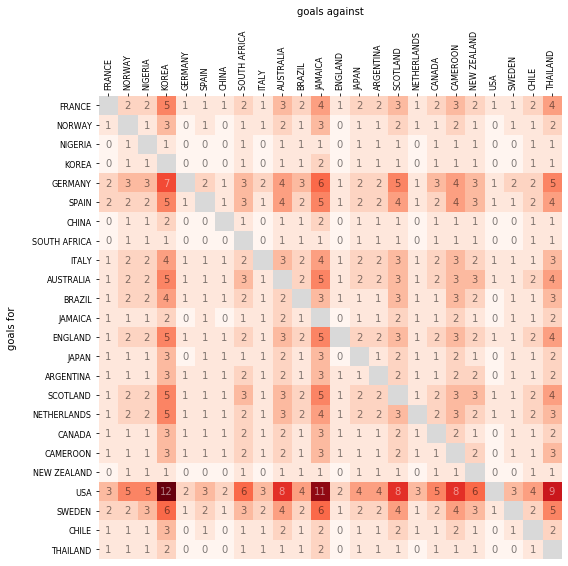

In [38]:
print("Truncated Normal Distribution")
vis.plot_goal_matrix(np.round(EG_poisson2.mean(axis=0)))

Chi-Squared Distribution


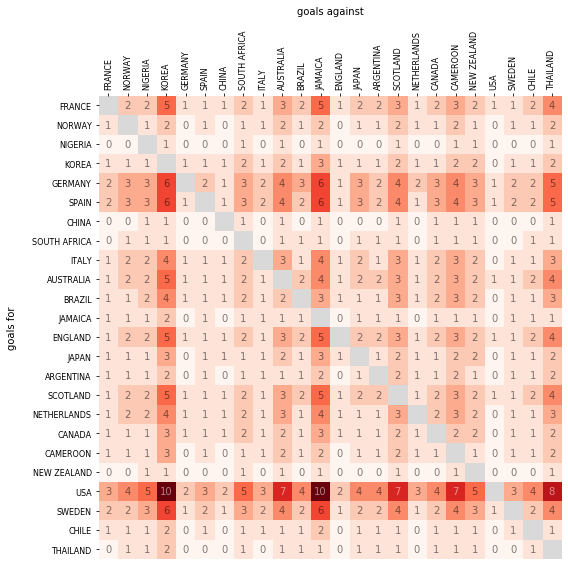

In [39]:
print("Chi-Squared Distribution")
vis.plot_goal_matrix(np.round(EG_poisson3.mean(axis=0)))

Gamma Distribution


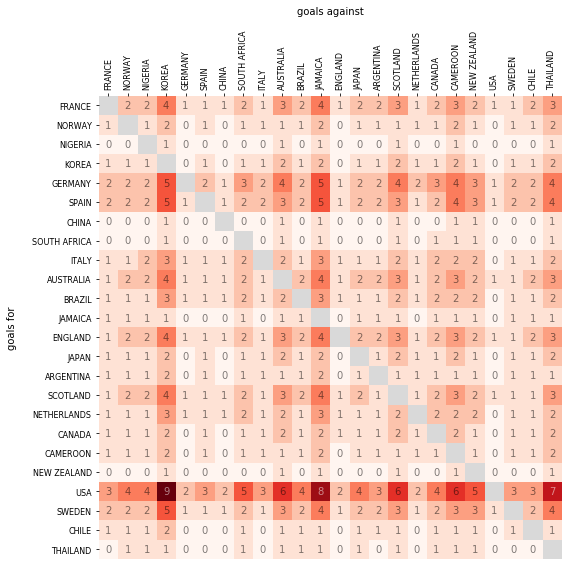

In [40]:
print("Gamma Distribution")
vis.plot_goal_matrix(np.round(EG_poisson4.mean(axis=0)))

You can see that modeling attempts as $\chi ^2$ and Gamma Distributions produce more conservative estimates than as a Truncated Normal. Below we can visualize how the predictions compare to the actual observed outcomes from each match. The visualization is of the absolute values of the differences of the observed outcomes (i.e. $| y - \hat{y} |$).

We can sum up the absolute deviations to compare model prediction accuracy (i.e. $\sum |y_i - \hat{y_i}|$).

In [19]:
ERR_poisson2 = np.absolute(G_all - np.round(EG_poisson2.mean(axis=0)))
ERR_poisson3 = np.absolute(G_all - np.round(EG_poisson3.mean(axis=0)))
ERR_poisson4 = np.absolute(G_all - np.round(EG_poisson4.mean(axis=0)))

print(ERR_poisson2[~np.isnan(ERR_poisson2)].sum())
print(ERR_poisson3[~np.isnan(ERR_poisson3)].sum())
print(ERR_poisson4[~np.isnan(ERR_poisson4)].sum())

62.0
59.0
60.0


The $\chi ^2$ distribution has the least error but that doesn't mean it's the best model. Let's take a look at the distribution of attempts produced from the 10,000 simulations for each of 3 teams: Thailand, USA, and Sweden.

Let's look at each team. Two are tournament outliers (Thailand and USA) and one is not (Sweden).

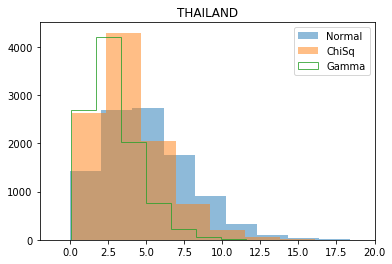

In [20]:
attempts2 = FIT2.extract(pars=['attempts'])['attempts']
attempts3 = FIT3.extract(pars=['attempts'])['attempts']
attempts4 = FIT4.extract(pars=['attempts'])['attempts']

vis.plt.hist(attempts2[:,-1], alpha=.5, label="Normal")
vis.plt.hist(attempts3[:,-1], alpha=.5, label="ChiSq")
vis.plt.hist(attempts4[:,-1], histtype='step', alpha=.8, label="Gamma")
vis.plt.title("THAILAND")
vis.plt.legend()
vis.plt.xlim(-2,20)
vis.plt.show()

**Thailand**

Pretty much any way you slice it, Thailand doesn't get a lot of attempts. This is because their average number of attempts is pretty low. In 3 games, they had a total of 13 attempts at goal: 2 against USA, 5 against Sweden, 6 against Chile. With that in mind, we might expect the median number of goals to be around 5 ish. All three models produce an attempts distribution that looks somewhat reasonable for this but tend to underestimate this number. But also, Thailand only has three data points. More data might make the distributions even more reasonable.

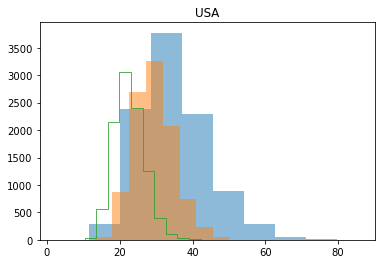

In [21]:
vis.plt.hist(attempts2[:,-4], alpha=.5)
vis.plt.hist(attempts3[:,-4], alpha=.5)
vis.plt.hist(attempts4[:,-4], histtype='step', alpha=.8)
vis.plt.title("USA")
vis.plt.xlim(-2,90)
vis.plt.show()

**USA**

The three distributions are very different. The normal distribution looks particularly wide; the spread goes from something like 15 to 90 attempts in a game with a median number of attempts around 35. That's a bit high so we know that a truncated normal in this case is going to produce high attempt estimates for USA and consequently may produce overestimated goal predictions. The $\chi ^2$ distribution is a bit better: min somewhere around 18, max somewhere around 50, mode around 30. But this still isn't quite reasonable or what we might expect. In other words, still not quite a good prior. The Gamma distribution produces the most reasonable estimates. When you look at the number of attempts team USA makes in their non-FIFA tournament games, this would not be an unreasonable distribution to choose as your prior. They tend to be a team with a lot of star players who take a lot of shots on goal but their average is somewhere on the order of 12-25 depending on the team. The Gamma distribution is not perfect but it is clearly the best of the three.

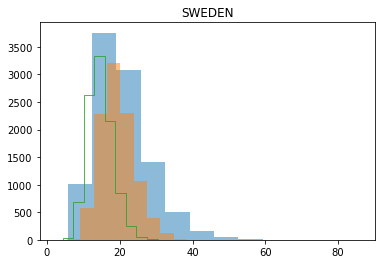

In [22]:
vis.plt.hist(attempts2[:,-3], alpha=.5)
vis.plt.hist(attempts3[:,-3], alpha=.5)
vis.plt.hist(attempts4[:,-3], histtype='step', alpha=.8)
vis.plt.title("SWEDEN")
vis.plt.xlim(-2,90)
vis.plt.show()

**Sweden**

As the only non-outlier team here, we can get a sense for how the priors on attempts perform for a typical or better than average team. In this case, we get similar shapes but again, the normal is a bit wide. The $\chi ^2$ is tighter but still runs a bit high. The Gamma is a *very* reasonable prior for attempts, with a mode around 17-18 and a good spread.